In [6]:
import sklearn.datasets
import matplotlib.pyplot as plt

In [27]:
n_classes=2
X, y = sklearn.datasets.make_blobs(n_features=100, centers=n_classes, cluster_std=1, n_samples=10000)

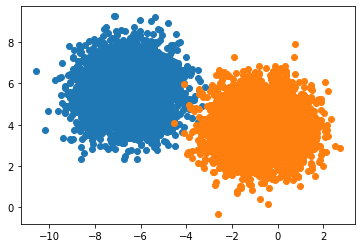

In [28]:
for i in range(n_classes):
    plt.scatter(X[y == i,10], X[y == i,1], label=str(i))


In [2]:
! mkdir -p data
! wget https://raw.githubusercontent.com/apwheele/Blog_Code/master/Python/PreppedCompas.csv -O data/PreppedCompas.csv

--2022-02-24 22:53:08--  https://raw.githubusercontent.com/apwheele/Blog_Code/master/Python/PreppedCompas.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2367572 (2.3M) [text/plain]
Saving to: ‘data/PreppredCompas.csv’

data/PreppredCompas 100%[===================>]   2.26M  11.2MB/s    in 0.2s    

2022-02-24 22:53:09 (11.2 MB/s) - ‘data/PreppredCompas.csv’ saved [2367572/2367572]



In [4]:
###############################################
# Front end libraries/data prep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

# Setting seeds
torch.manual_seed(10)
np.random.seed(10)

# Prepping the Compas data and making train/test
recid = pd.read_csv('data/PreppedCompas.csv')

#Preparing the variables I want
recid_prep = recid[['Recid30','CompScore.1','CompScore.2','CompScore.3',
                    'juv_fel_count','YearsScreening']].copy()
recid_prep['Male'] = 1*(recid['sex'] == "Male")
recid_prep['Fel'] = 1*(recid['c_charge_degree'] == "F")
recid_prep['Mis'] = 1*(recid['c_charge_degree'] == "M")
dum_race = pd.get_dummies(recid['race'])

# White for reference category
for d in list(dum_race):
    if d != 'Caucasion':
        recid_prep[d] = dum_race[d]

# reference category is separated/unknown/widowed
dum_mar = pd.get_dummies(recid['marital_status'])
recid_prep['Single'] = dum_mar['Single']
recid_prep['Married'] = dum_mar['Married'] + dum_mar['Significant Other']

#Now generating train and test set
recid_prep['Train'] = np.random.binomial(1,0.75,len(recid_prep))
recid_train = recid_prep[recid_prep['Train'] == 1].copy()
recid_test = recid_prep[recid_prep['Train'] == 0].copy()

#Independant variables
ind_vars = ['CompScore.1','CompScore.2','CompScore.3',
            'juv_fel_count','YearsScreening','Male','Fel','Mis',
            'African-American','Asian','Hispanic','Native American','Other',
            'Single','Married']

# Dependent variable
y_var = 'Recid30'
###############################################

In [5]:
# Initial pytorch model class
class logit_pytorch(torch.nn.Module):
    def __init__(self, nvars, device, activate='relu', bias=True,
                 final='sigmoid'):
        """
        Construct parameters for the coefficients 
        activate - either string ('relu' or 'tanh', 
                   or pass in your own torch function
        bias - whether to include bias (intercept) in model
        final - use either 'sigmoid' to squash to probs, or 'clamp'
                or pass in your own torch function
        device - torch device to construct the tensors
                 default cuda:0 if available
        """
        super(logit_pytorch, self).__init__()
        # Creating the coefficient parameters
        self.coef = torch.nn.Parameter(torch.rand((nvars,1),
                    device=device)/10)
        # If no bias it is 0
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,
                    device=device))
        else:
            self.bias = torch.zeros(1, device=device)
        # Various activation functions
        if activate == 'relu':
            self.trans = torch.nn.ReLU()
        elif activate == 'tanh':
            self.trans = torch.nn.Tanh()
        else:
            self.trans = activate
        if final == 'sigmoid':
            self.final = torch.nn.Sigmoid()
        elif final == 'clamp':
            # Defining my own clamp function
            def tclamp(input):
                return torch.clamp(input,min=0,max=1)
            self.final = tclamp
        else: 
            # Can pass in your own function
            self.final = final
    def forward(self, x):
        """
        predicted probability
        """
        output = self.bias + torch.mm(x, self.trans(self.coef))
        return self.final(output)

In [6]:
# Creating a class to instantiate model to data and then fit
class pytorchLogit():
    def __init__(self, loss='logit', iters=25001, 
                 activate='relu', bias=True, 
                 final='sigmoid', device='gpu',
                 printn=1000):
        """
        loss - either string 'logit' or 'brier' or own pytorch function
        iters - number of iterations to fit (default 25000)
        activate - either string ('relu' or 'tanh', 
                   or pass in your own torch function
        bias - whether to include bias (intercept) in model
        final - use either 'sigmoid' to squash to probs, or 'clamp'
                or pass in your own torch function. Should not use clamp
                with default logit loss
        opt - ?optimizer? should add an option for this
        device - torch device to construct the tensors
                 default cuda:0 if available
        printn - how often to check the fit (default 1000 iters)
        """
        super(pytorchLogit, self).__init__()
        if loss == 'logit':
            self.loss = torch.nn.BCELoss()
            self.loss_name = 'logit'
        elif loss == 'brier':
            self.loss = torch.nn.MSELoss(reduction='mean')
            self.loss_name = 'brier'
        else:
            self.loss = loss
            self.loss_name = 'user defined function'
        # Setting the torch device
        if device == 'gpu':
            try:
                self.device = torch.device("cuda:0")
                print(f'Torch device GPU defaults to cuda:0')
            except:
                print('Unsuccessful setting to GPU, defaulting to CPU')
                self.device = torch.device("cpu")
        elif device == 'cpu':
            self.device = torch.device("cpu")
        else:
            self.device = device #can pass in whatever
        self.iters = iters
        self.mod = None
        self.activate = activate
        self.bias = bias
        self.final = final
        self.printn = printn
        # Other stats to carry forward
        self.loss_metrics = []
        self.epoch = 0
    def fit(self, X, y, outX=None, outY=None):
        x_ten = torch.tensor(X.to_numpy(), dtype=torch.float,
                             device=self.device)
        y_ten = torch.tensor(pd.DataFrame(y).to_numpy(), dtype=torch.float,
                             device=self.device)
        # Only needed if you pass in an out of sample to check as well
        if outX is not None:
            x_out_ten = torch.tensor(outX.to_numpy(), dtype=torch.float,
                             device=self.device)
            y_out_ten = torch.tensor(pd.DataFrame(outY).to_numpy(), dtype=torch.float,
                             device=self.device)
        self.epoch += 1
        # If mod is not already created, create a new one, else update prior
        if self.mod is None:
            loc_mod = logit_pytorch(nvars=X.shape[1], activate=self.activate, 
                                    bias=self.bias, final=self.final, 
                                    device=self.device)
            self.mod = loc_mod
        else:
            loc_mod = self.mod
        opt = torch.optim.Adam(loc_mod.parameters(), lr=1e-4)
        crit = self.loss
        for t in range(self.iters):
            opt.zero_grad()
            y_pred = loc_mod(x_ten)
            loss = crit(y_pred,y_ten)
            if t % self.printn == 0:
                if outX is not None:
                    pred_os = loc_mod(x_out_ten)
                    loss_os = crit(pred_os,y_out_ten)
                    res_tup = (self.epoch, t, loss.item(), loss_os.item())
                    print(f'{t}: insample {res_tup[2]:.4f}, outsample {res_tup[3]:.4f}')
                else:
                    res_tup = (self.epoch, t, loss.item(), None)
                    print(f'{t}: insample {res_tup[2]:.5f}')
                self.loss_metrics.append(res_tup)
            loss.backward()
            opt.step()
    def predict_proba(self, X):
        x_ten = torch.tensor(X.to_numpy(), dtype=torch.float,
                             device=self.device)
        res = self.mod(x_ten)
        pp = res.cpu().detach().numpy()
        return np.concatenate((1-pp,pp), axis=1)
    def loss_stats(self, plot=True, select=0):
        pd_stats = pd.DataFrame(self.loss_metrics, columns=['epoch','iteration',
                                                            'insamploss','outsamploss'])
        if plot:
            pd_stats2 = pd_stats.rename(columns={'insamploss':'In Sample Loss', 'outsamploss':'Out of Sample Loss'})
            pd_stats2 = pd_stats2[pd_stats2['iteration'] > select].copy()
            ax = pd_stats2[['iteration','In Sample Loss','Out of Sample Loss']].plot.line(x='iteration', 
                            ylabel=f'{self.loss_name} loss')
            plt.show()
        return pd_stats

In [7]:
# Creating a model and fitting
mod = pytorchLogit()
mod.fit(recid_train[ind_vars], recid_train[y_var])

Torch device GPU defaults to cuda:0
0: insample 2.12373
1000: insample 0.65643
2000: insample 0.64303
3000: insample 0.63493
4000: insample 0.62720
5000: insample 0.62115
6000: insample 0.61728
7000: insample 0.61536
8000: insample 0.61470
9000: insample 0.61455
10000: insample 0.61449
11000: insample 0.61446
12000: insample 0.61444
13000: insample 0.61444
14000: insample 0.61444
15000: insample 0.61444
16000: insample 0.61444
17000: insample 0.61444
18000: insample 0.61444
19000: insample 0.61444
20000: insample 0.61444
21000: insample 0.61444
22000: insample 0.61444
23000: insample 0.61444
24000: insample 0.61444
25000: insample 0.61444


In [8]:
mod.mod

logit_pytorch(
  (trans): ReLU()
  (final): Sigmoid()
)